In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
print(os.getcwd())
os.chdir(r'/content/gdrive/MyDrive/Trial/Real')
print(os.getcwd())

Mounted at /content/gdrive
/content
/content/gdrive/MyDrive/Trial/Real


In [ ]:
os.getcwd()

'/data/private/Thesis/Trial_real_mc'

In [ ]:
x = np.load('Patches/Train/x1.npy')
y = np.load('Patches/Train/yb.npy')

In [ ]:
# Split dataset into training and validation
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, random_state=38)

In [ ]:
# Split (again) from training dataset into training and testing
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=38)

In [ ]:
del x
del y

In [ ]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(1600, 256, 256, 2)
(600, 256, 256, 2)
(600, 256, 256, 2)
(1600, 256, 256, 1)
(600, 256, 256, 1)
(600, 256, 256, 1)


In [ ]:
# 1hot for label datasets
train_y = tf.keras.utils.to_categorical(train_y)
val_y = tf.keras.utils.to_categorical(val_y)
test_y_1 = tf.keras.utils.to_categorical(test_y)

### **Build Networks**

In [ ]:
def unet(patch_size, n_bands, n_classes):
    inputs = tf.keras.Input(shape=(patch_size, patch_size, n_bands))

    # ENCODER
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)
    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv4)

    # BOTTOM
    conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(pool4)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.ReLU()(conv5)
    conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.ReLU()(conv5)

    # DECODER
    # BN_Conv2DTranspose_ReLU: Biswas. #Upsampling2D_Conv2DTranspose_BN_ReLU: Chibber. #Upsamling2D_CONV_BN_ReLU: Practical
    # deconv = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides)
    deconv4 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same')(conv5)
    merge4 = tf.keras.layers.concatenate([conv4, deconv4]) #order, axis=3
    uconv4 = tf.keras.layers.BatchNormalization()(merge4)
    uconv4 = tf.keras.layers.ReLU()(uconv4)
    uconv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(uconv4)
    uconv4 = tf.keras.layers.BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.ReLU()(uconv4)
    uconv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(uconv4)
    uconv4 = tf.keras.layers.BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.ReLU()(uconv4)

    deconv3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same')(uconv4)
    merge3 = tf.keras.layers.concatenate([conv3, deconv3])
    uconv3 = tf.keras.layers.BatchNormalization()(merge3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same')(uconv3)
    merge2 = tf.keras.layers.concatenate([conv2, deconv2])
    uconv2 = tf.keras.layers.BatchNormalization()(merge2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)

    deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same')(uconv2)
    merge1 = tf.keras.layers.concatenate([conv1, deconv1])
    uconv1 = tf.keras.layers.BatchNormalization()(merge1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)

    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation="softmax")(uconv1)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# define parameters
PATCH_SIZE = 256
N_BANDS = 2
N_CLASSES = 2 #0: Backkground, 1: Industrial, 2: Smallholder
BATCH_SIZE = 10
EPOCHS = 150

In [ ]:
model = unet(PATCH_SIZE, N_BANDS, N_CLASSES)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 64  1216        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_88 (BatchN  (None, 256, 256, 64  256        ['conv2d_76[0][0]']              
 ormalization)                  )                                                           

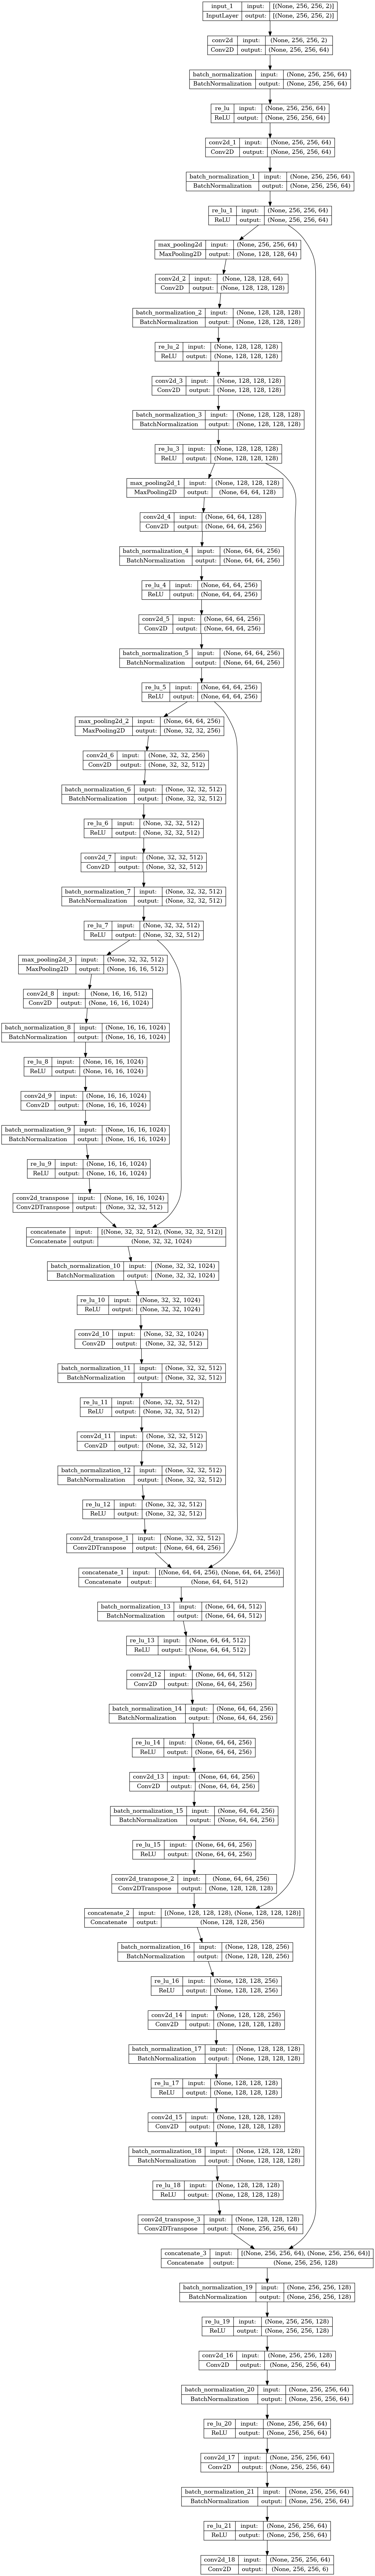

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### **Training**

In [ ]:
conditions= [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='Output/s1_relu_1e-05/model.{epoch:02d}--{val_loss:.2f}.h5', save_best_only=True)]

In [ ]:
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(val_x, val_y), callbacks=conditions, verbose=1)

Epoch 1/150
160/160 [==============================] - 32s 117ms/step - loss: 0.3867 - accuracy: 0.8303 - val_loss: 0.6597 - val_accuracy: 0.6614
Epoch 2/150
160/160 [==============================] - 16s 100ms/step - loss: 0.2553 - accuracy: 0.9007 - val_loss: 0.9549 - val_accuracy: 0.3123
Epoch 3/150
160/160 [==============================] - 16s 100ms/step - loss: 0.2336 - accuracy: 0.9082 - val_loss: 1.4408 - val_accuracy: 0.3124
Epoch 4/150
160/160 [==============================] - 16s 100ms/step - loss: 0.2350 - accuracy: 0.9071 - val_loss: 1.6913 - val_accuracy: 0.3125
Epoch 5/150
160/160 [==============================] - 16s 100ms/step - loss: 0.2206 - accuracy: 0.9125 - val_loss: 1.6288 - val_accuracy: 0.3133
Epoch 6/150
160/160 [==============================] - 16s 100ms/step - loss: 0.2168 - accuracy: 0.9153 - val_loss: 2.2862 - val_accuracy: 0.3124
Epoch 7/150
160/160 [==============================] - 16s 100ms/step - loss: 0.2136 - accuracy: 0.9167 - val_loss: 2.0621 -

KeyboardInterrupt: ignored

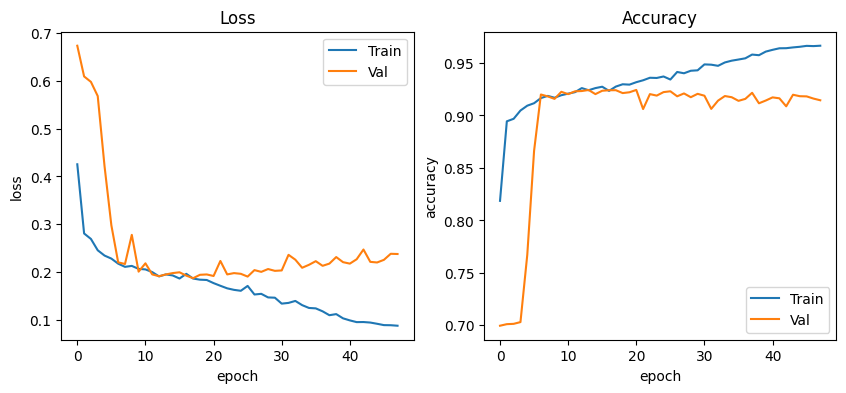

In [ ]:
# plot loss and accuracy across epochs
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['Train', 'Val'], loc='upper right')

# accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['Train', 'Val'], loc='lower right')

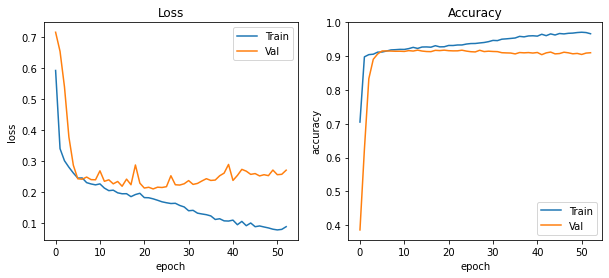

In [ ]:
# plot loss and accuracy across epochs
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['Train', 'Val'], loc='upper right')

# accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['Train', 'Val'], loc='lower right')

In [ ]:
val_loss, val_acc = model.evaluate(val_x, val_y)
print(f"\nValidation accuracy: {100 * val_acc:.2f}%")

15/15 [==============================] - 10s 257ms/step - loss: 0.1876 - accuracy: 0.9241

Validation accuracy: 92.41%


In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y_1)
print(f"\nTesting accuracy: {100 * test_acc:.2f}%")

4/4 [==============================] - 3s 1s/step - loss: 0.1894 - accuracy: 0.9244

Testing accuracy: 92.44%


In [ ]:
model.save("Output/unets1_bdescals_1e-5_softmax.h5")

### **Apply on random patches**

1/1 [==============================] - 0s 56ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

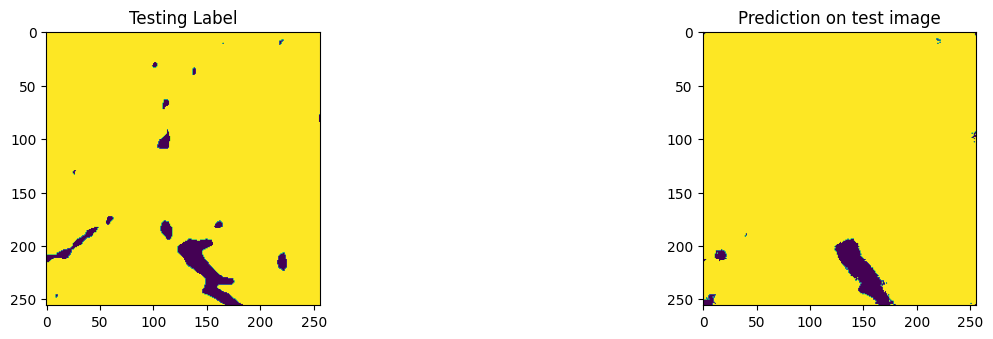

In [ ]:
import random

test_img_num = random.randint(0, len(test_x))
test_img = test_x[test_img_num]
groundtruth = test_y[test_img_num]

test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

# plot
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Label')
plt.imshow(groundtruth)

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show